In this notebook, we are going to see the linear models with
- $u$ (MODEL 0)
- $u, sf, cw$ (MODEL 1)
- $u \cdot sf$  (MODEL 2)

and its offline/online performance under perturbation

In [47]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from qbo1d.stochastic_forcing import sample_sf_cw

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils

In [48]:
# data generator:
# parameter dicts

sfe = [3.7e-3, 3.8e-3, 3.2e-3, 3.8e-3, 3.8e-3]
sfv = [1e-8, 9e-8, 9e-8, 9e-10, 9e-8]
cwe = [32, 32, 40, 32, 32]
cwv = [225, 225, 225, 225, 225]
corr = [0.75, 0.75, 0.75, 0.75, -0.75]
seed = [int(21*9+8), int(21*9+7), int(21*6+15), int(21*12+5), int(21*2+10)]

# generate the matrix form

para_mat = np.array([sfe, sfv, cwe, cwv, corr, seed]).T


def data_generator(state=1):
    '''
    Input: state(0~4)
    STATE = 0 -> old control
    STATE = 1 -> new control
    STATE = 2 -> different mean
    STATE = 3 -> different variance
    STATE = 4 -> anti-correlation(non-physical) 

    Output: (u, s, sf, cw, solver)
    '''


    # Load the data manually
    # it takes 40 seconds

    t_max = 360 * 108 * 86400
    nsteps = 360 * 108
    nspinup = 360 * 12
    ntot = int(nsteps - nspinup)

    torch.set_default_dtype(torch.float64)


    # scenario 0 (control)
    # --------------------
    solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
    model = WaveSpectrum(solver, *para_mat[state])
    time = solver.time
    z = solver.z
    u = solver.solve(source_func=model)

    return u, model.s, model.sf, model.cw, solver


In [49]:
# Plotting function

def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True, text='model 0'):
    
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()
    
    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    
    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    # Set ticks
    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    # if u, the display \tau and \sigma
    if isu:
        ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
        ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # The label it displays
    # u/s has different dimension
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    # Color bars
    if isu:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
        boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
        label=label)
    else:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% .2e', 
        boundaries=np.linspace(cmin, cmax, 11), orientation='horizontal',
        label=label)
    
    plt.title(text)

    plt.legend()
    plt.show()

def rMSE(s_pred, s_gt, s_std):
    error = (s_gt - s_pred)
    SSE = sum(error ** 2)
    MSE = SSE/s_gt.shape[0]
    RMSE = MSE**.5
    return RMSE/s_std
    
def plot_rmse(*args):
    for i in range(len(args)):
        plt.plot(range(len(args[i])), args[i], label='model' + str(i))
    
    plt.xlabel('z level(indices)')
    plt.ylabel('rMSE')
    plt.title('Plot of rMSEs')
    plt.legend()
    plt.show()


def para_for_plotting(solver, u):
    # calculate amplitude and period
    spinup_time = 12*360*86400

    amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
    amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
    tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)

    return {'amp25':amp25, 'amp20':amp20, 'period':tau25}

def plot_wind_level(u, level=35, text='MODEL 0'):
    plt.plot(u[:, level])
    plt.xlabel('timestep')
    plt.ylabel('zonal wind at z=' + str(level))
    plt.title(text)
    plt.show()


# Control

In [50]:
STATE = 1
u, s, sf, cw, solver = data_generator(state=STATE)

In [51]:
nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :] 
sf = sf[nspinup:nsteps]
cw = cw[nspinup:nsteps]

U_0 = u

U_1 = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])

U_2 = torch.diag(sf) @ u

# Here U is the features and s is the label

U_train_0, U_test_0, s_train_0, s_test_0 = train_test_split(U_0, s, test_size=0.2, random_state=42)
U_train_1, U_test_1, s_train_1, s_test_1 = train_test_split(U_1, s, test_size=0.2, random_state=42)
U_train_2, U_test_2, s_train_2, s_test_2 = train_test_split(U_2, s, test_size=0.2, random_state=42)

## Training

In [52]:
reg_0 = LinearRegression().fit(U_train_0, s_train_0)
reg_1 = LinearRegression().fit(U_train_1, s_train_1)
reg_2 = LinearRegression().fit(U_train_2, s_train_2)

## Offline
We are going to show:
- $R^{2}$
- mean rMSE
- rMSEs in one plot

================== Model 0 ==================
R^2: 0.8940
mean root MSE(After Normalization): 0.3045
================== Model 1 ==================
R^2: 0.8940
mean root MSE(After Normalization): 0.3045
================== Model 2 ==================
R^2: 0.8892
mean root MSE(After Normalization): 0.3065


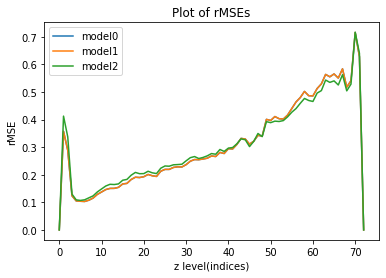

In [53]:
prediction_0 = reg_0.predict(U_test_0)
rMSE_0 = rMSE(prediction_0, s_test_0, s.std()+1e-32)

prediction_1 = reg_1.predict(U_test_1)
rMSE_1 = rMSE(prediction_1, s_test_1, s.std()+1e-32)

prediction_2 = reg_2.predict(U_test_2)
rMSE_2 = rMSE(prediction_2, s_test_2, s.std()+1e-32)

print('================== Model 0 ==================')
print(f'R^2: {reg_0.score(U_test_0, s_test_0):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_0.mean():.4f}')

print('================== Model 1 ==================')
print(f'R^2: {reg_1.score(U_test_1, s_test_1):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_1.mean():.4f}')

print('================== Model 2 ==================')
print(f'R^2: {reg_2.score(U_test_2, s_test_2):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_2.mean():.4f}')

plot_rmse(rMSE_0, rMSE_1, rMSE_2)


## Online

In [54]:
torch.set_default_dtype(torch.float64)

# We set the tmax a little bit longer
# the default is 360*96*86400
# now we set it to 360*96
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], *para_mat[STATE])

# u
model_ML_0 = lambda x : torch.tensor(reg_0.coef_) @ x + torch.tensor(reg_0.intercept_)


u_ML_0 = solver_ML.solve(source_func=model_ML_0)
u_ML_0 = u_ML_0.detach()



# u, sf, cw
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)
model_ML_1 = lambda x : torch.tensor(reg_1.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg_1.intercept_)


u_ML_1 = solver_ML.solve(source_func=model_ML_1)
u_ML_1 = u_ML_0.detach()

# u \cdot sf

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

model_ML_2 = lambda x : torch.tensor(reg_2.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg_2.intercept_)


u_ML_2 = solver_ML.solve(source_func=model_ML_2)
u_ML_2 = u_ML_2.detach()



No handles with labels found to put in legend.


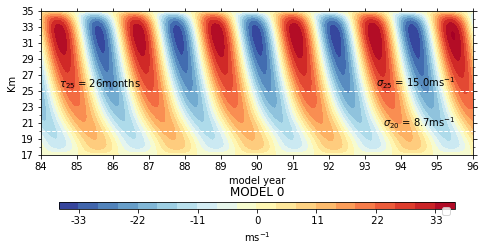

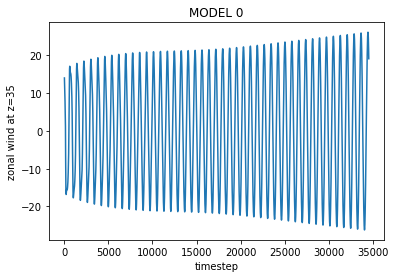

No handles with labels found to put in legend.


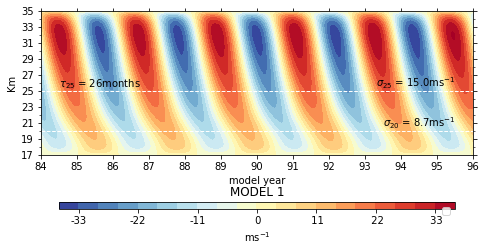

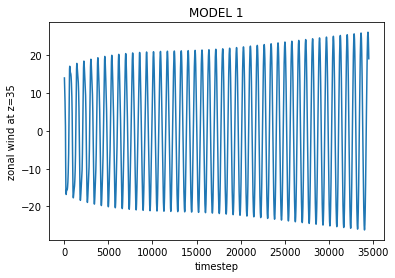

No handles with labels found to put in legend.


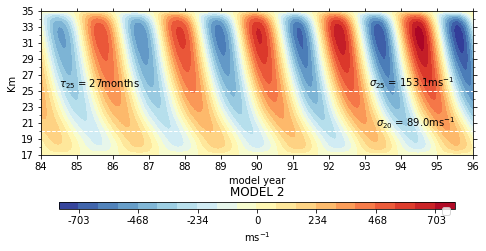

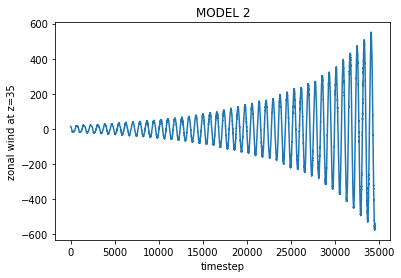

In [55]:
# Visualization

plot_76_tensors(u_ML_0, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_0), text='MODEL 0')
plot_wind_level(u_ML_0, text='MODEL 0')

plot_76_tensors(u_ML_1, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_1), text='MODEL 1')
plot_wind_level(u_ML_1, text='MODEL 1')

plot_76_tensors(u_ML_2, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_2), text='MODEL 2')
plot_wind_level(u_ML_2, text='MODEL 2')


# Perturbed - 1
STATE = 2 <-> Biased means

In [56]:
STATE = 2
u, s, sf, cw, solver = data_generator(state=STATE)

In [57]:
nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :] 
sf = sf[nspinup:nsteps]
cw = cw[nspinup:nsteps]

U_0 = u

U_1 = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])

U_2 = torch.diag(sf) @ u

## Offline

================== Model 0 ==================
R^2: 0.8077
mean root MSE(After Normalization): 0.3902
================== Model 1 ==================
R^2: 0.8076
mean root MSE(After Normalization): 0.3903
================== Model 2 ==================
R^2: 0.8629
mean root MSE(After Normalization): 0.3258


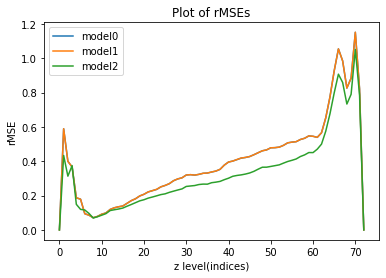

In [58]:
prediction_0 = reg_0.predict(U_0)
rMSE_0 = rMSE(prediction_0, s, s.std()+1e-32)

prediction_1 = reg_1.predict(U_1)
rMSE_1 = rMSE(prediction_1, s, s.std()+1e-32)

prediction_2 = reg_2.predict(U_2)
rMSE_2 = rMSE(prediction_2, s, s.std()+1e-32)

print('================== Model 0 ==================')
print(f'R^2: {reg_0.score(U_0, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_0.mean():.4f}')

print('================== Model 1 ==================')
print(f'R^2: {reg_1.score(U_1, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_1.mean():.4f}')

print('================== Model 2 ==================')
print(f'R^2: {reg_2.score(U_2, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_2.mean():.4f}')

plot_rmse(rMSE_0, rMSE_1, rMSE_2)


## Online

In [59]:
torch.set_default_dtype(torch.float64)

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], *para_mat[STATE])

# u
model_ML_0 = lambda x : torch.tensor(reg_0.coef_) @ x + torch.tensor(reg_0.intercept_)


u_ML_0 = solver_ML.solve(source_func=model_ML_0)
u_ML_0 = u_ML_0.detach()



# u, sf, cw
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)
model_ML_1 = lambda x : torch.tensor(reg_1.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg_1.intercept_)


u_ML_1 = solver_ML.solve(source_func=model_ML_1)
u_ML_1 = u_ML_0.detach()

# u \cdot sf

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

model_ML_2 = lambda x : torch.tensor(reg_2.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg_2.intercept_)


u_ML_2 = solver_ML.solve(source_func=model_ML_2)
u_ML_2 = u_ML_2.detach()


No handles with labels found to put in legend.


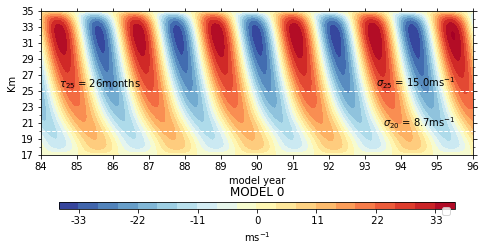

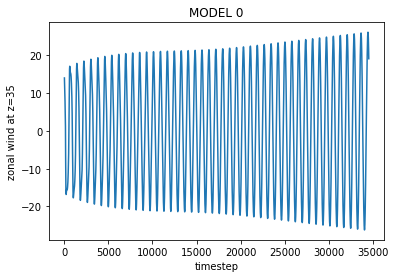

No handles with labels found to put in legend.


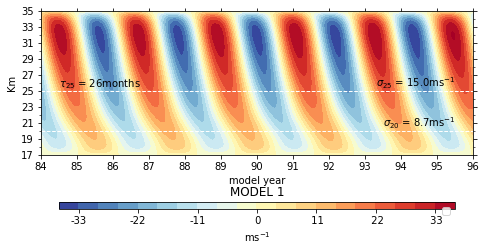

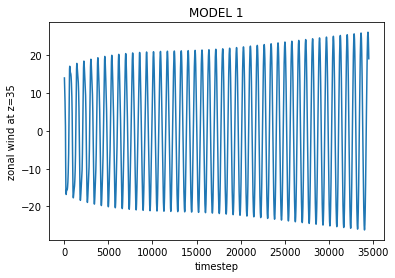

No handles with labels found to put in legend.


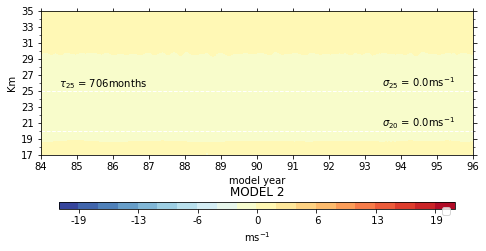

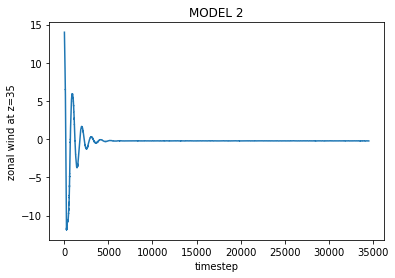

In [60]:
# Visualization

plot_76_tensors(u_ML_0, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_0), text='MODEL 0')
plot_wind_level(u_ML_0, text='MODEL 0')

plot_76_tensors(u_ML_1, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_1), text='MODEL 1')
plot_wind_level(u_ML_1, text='MODEL 1')

plot_76_tensors(u_ML_2, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_2), text='MODEL 2')
plot_wind_level(u_ML_2, text='MODEL 2')



# Perturbed - 2
STATE = 3 <-> Biased Variance

In [61]:
STATE = 3
u, s, sf, cw, solver = data_generator(state=STATE)

In [62]:
nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :] 
sf = sf[nspinup:nsteps]
cw = cw[nspinup:nsteps]

U_0 = u

U_1 = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])

U_2 = torch.diag(sf) @ u

## Offline

================== Model 0 ==================
R^2: 0.8888
mean root MSE(After Normalization): 0.3069
================== Model 1 ==================
R^2: 0.8888
mean root MSE(After Normalization): 0.3069
================== Model 2 ==================
R^2: 0.8875
mean root MSE(After Normalization): 0.3082


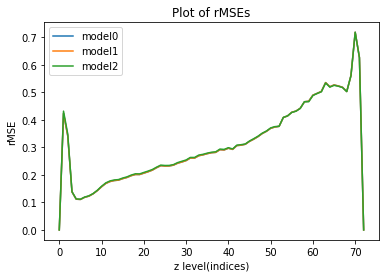

In [63]:
prediction_0 = reg_0.predict(U_0)
rMSE_0 = rMSE(prediction_0, s, s.std()+1e-32)

prediction_1 = reg_1.predict(U_1)
rMSE_1 = rMSE(prediction_1, s, s.std()+1e-32)

prediction_2 = reg_2.predict(U_2)
rMSE_2 = rMSE(prediction_2, s, s.std()+1e-32)

print('================== Model 0 ==================')
print(f'R^2: {reg_0.score(U_0, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_0.mean():.4f}')

print('================== Model 1 ==================')
print(f'R^2: {reg_1.score(U_1, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_1.mean():.4f}')

print('================== Model 2 ==================')
print(f'R^2: {reg_2.score(U_2, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_2.mean():.4f}')

plot_rmse(rMSE_0, rMSE_1, rMSE_2)


## Online

In [64]:
torch.set_default_dtype(torch.float64)

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], *para_mat[STATE])

# u
model_ML_0 = lambda x : torch.tensor(reg_0.coef_) @ x + torch.tensor(reg_0.intercept_)


u_ML_0 = solver_ML.solve(source_func=model_ML_0)
u_ML_0 = u_ML_0.detach()



# u, sf, cw
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)
model_ML_1 = lambda x : torch.tensor(reg_1.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg_1.intercept_)


u_ML_1 = solver_ML.solve(source_func=model_ML_1)
u_ML_1 = u_ML_0.detach()

# u \cdot sf

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

model_ML_2 = lambda x : torch.tensor(reg_2.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg_2.intercept_)


u_ML_2 = solver_ML.solve(source_func=model_ML_2)
u_ML_2 = u_ML_2.detach()


No handles with labels found to put in legend.


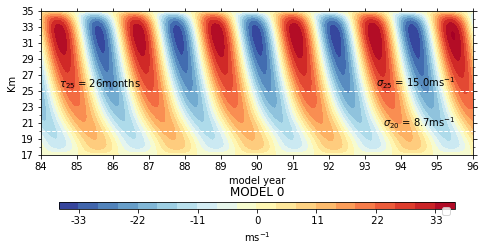

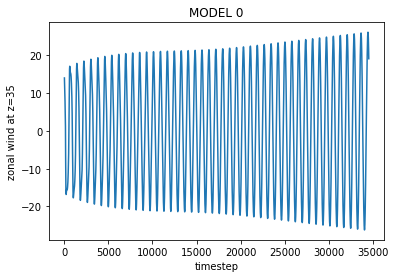

No handles with labels found to put in legend.


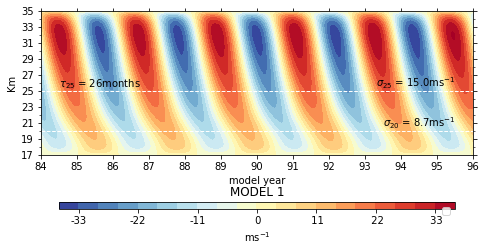

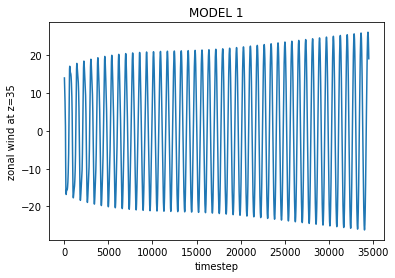

No handles with labels found to put in legend.


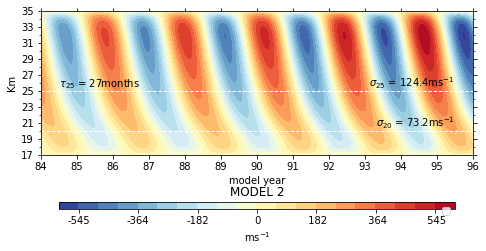

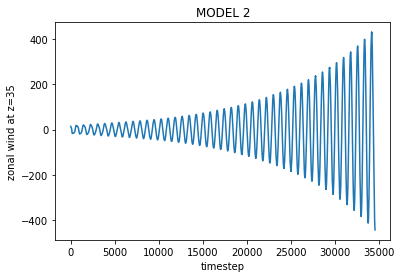

In [65]:
# Visualization

plot_76_tensors(u_ML_0, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_0), text='MODEL 0')
plot_wind_level(u_ML_0, text='MODEL 0')

plot_76_tensors(u_ML_1, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_1), text='MODEL 1')
plot_wind_level(u_ML_1, text='MODEL 1')

plot_76_tensors(u_ML_2, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_2), text='MODEL 2')
plot_wind_level(u_ML_2, text='MODEL 2')



# Perturbed - 3

STATE = 4 <-> Anti-correlation(Non-physical)

In [66]:
STATE = 4
u, s, sf, cw, solver = data_generator(state=STATE)

In [67]:
nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :] 
sf = sf[nspinup:nsteps]
cw = cw[nspinup:nsteps]

U_0 = u

U_1 = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])

U_2 = torch.diag(sf) @ u

## Offline

================== Model 0 ==================
R^2: 0.8613
mean root MSE(After Normalization): 0.3389
================== Model 1 ==================
R^2: 0.8613
mean root MSE(After Normalization): 0.3390
================== Model 2 ==================
R^2: 0.8744
mean root MSE(After Normalization): 0.3261


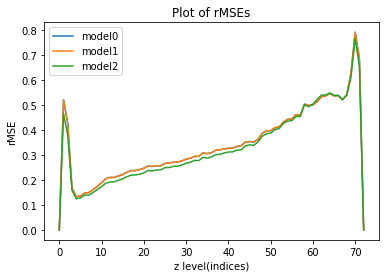

In [68]:
prediction_0 = reg_0.predict(U_0)
rMSE_0 = rMSE(prediction_0, s, s.std()+1e-32)

prediction_1 = reg_1.predict(U_1)
rMSE_1 = rMSE(prediction_1, s, s.std()+1e-32)

prediction_2 = reg_2.predict(U_2)
rMSE_2 = rMSE(prediction_2, s, s.std()+1e-32)

print('================== Model 0 ==================')
print(f'R^2: {reg_0.score(U_0, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_0.mean():.4f}')

print('================== Model 1 ==================')
print(f'R^2: {reg_1.score(U_1, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_1.mean():.4f}')

print('================== Model 2 ==================')
print(f'R^2: {reg_2.score(U_2, s):.4f}')
print(f'mean root MSE(After Normalization): {rMSE_2.mean():.4f}')

plot_rmse(rMSE_0, rMSE_1, rMSE_2)


## Online

In [69]:
torch.set_default_dtype(torch.float64)

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], *para_mat[STATE])

# u
model_ML_0 = lambda x : torch.tensor(reg_0.coef_) @ x + torch.tensor(reg_0.intercept_)


u_ML_0 = solver_ML.solve(source_func=model_ML_0)
u_ML_0 = u_ML_0.detach()



# u, sf, cw
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)
model_ML_1 = lambda x : torch.tensor(reg_1.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg_1.intercept_)


u_ML_1 = solver_ML.solve(source_func=model_ML_1)
u_ML_1 = u_ML_0.detach()

# u \cdot sf

solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

model_ML_2 = lambda x : torch.tensor(reg_2.coef_) @ (sf_ML[solver_ML.current_step]*x) + torch.tensor(reg_2.intercept_)


u_ML_2 = solver_ML.solve(source_func=model_ML_2)
u_ML_2 = u_ML_2.detach()


No handles with labels found to put in legend.


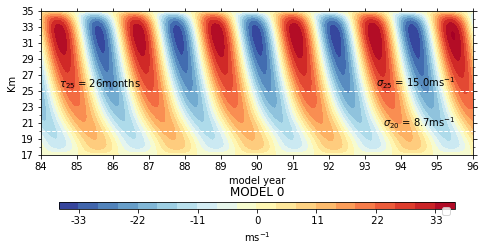

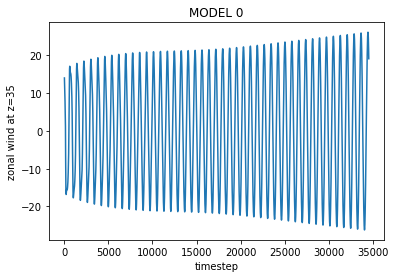

No handles with labels found to put in legend.


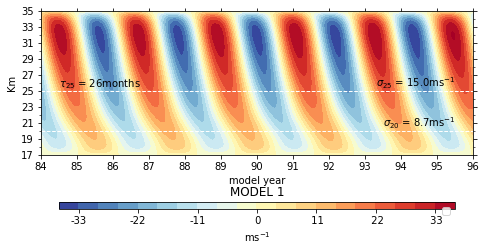

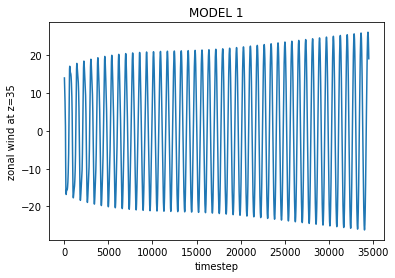

No handles with labels found to put in legend.


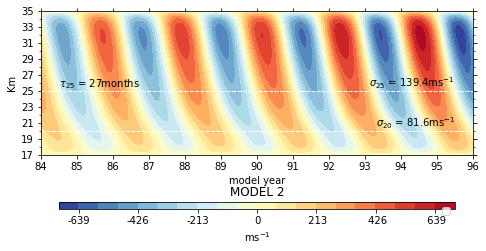

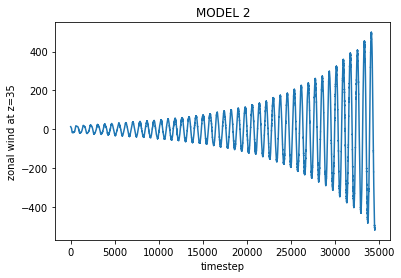

In [70]:
# Visualization

plot_76_tensors(u_ML_0, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_0), text='MODEL 0')
plot_wind_level(u_ML_0, text='MODEL 0')

plot_76_tensors(u_ML_1, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_1), text='MODEL 1')
plot_wind_level(u_ML_1, text='MODEL 1')

plot_76_tensors(u_ML_2, solver=solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML_2), text='MODEL 2')
plot_wind_level(u_ML_2, text='MODEL 2')